In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
import math
import datetime
import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.utils import class_weight
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.models import load_model
import joblib
# import py_vollib.black_scholes.implied_volatility
import multiprocessing
from multiprocessing import Pool
import os
import py_vollib.black_scholes.implied_volatility as vb
import statistics
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


In [6]:
def c_int(lst):
    df = pd.DataFrame(lst)
    df = df.sort_values(by = 0).reset_index(drop=True)
    cp1 = df[np.logical_and(df[0] >= -2,df[0] <= 2)]
    return (len(cp1)/len(df))*100

def worker(date,UnderlyingPrice, StrikePrice, InterestRate, Daystoexpiration,callPrice):
#     implied_volatility(price, S, K, t, r, flag)
#     l_iv=vb.implied_volatility(l_callPrice, UnderlyingPrice, StrikePrice, Daystoexpiration/365, InterestRate/100, 'c')
#     h_iv=vb.implied_volatility(h_callPrice, UnderlyingPrice, StrikePrice, Daystoexpiration/365, InterestRate/100, 'c')
    a_iv=vb.implied_volatility(callPrice, UnderlyingPrice, StrikePrice, Daystoexpiration/365, InterestRate/100, 'c')
    return a_iv

In [9]:
for ov in range(0,1):

    path_var = 1
    
    print("\nOV={}".format(ov))

    if (path_var == 1):
        filepath = '/home/docboy/Desktop/Option_Pricing/datasets/'
        modelpath = '/home/docboy/Desktop/Option_Pricing/pickles/'


    else:
        filepath = '/home/sharan/Desktop/OptionPricing-master/datasets/'
        modelpath = '/home/sharan/Desktop/OptionPricing-master/pickles/'



    nfty = filepath + 'NIFTY50_feature_set_COV_complete.csv'
    nfty_ecdf = filepath + 'NIFTY50_feature_set_ECDF_complete.csv'

    nfty_19= filepath + 'NIFTY50_2019_feature_set_COV_complete.csv'
    nfty_ecdf_19= filepath + 'NIFTY50_2019_feature_set_ECDF_complete.csv'

    bnfty = filepath + 'BANKNIFTY_feature_set_COV_complete.csv'
    bnfty_ecdf = filepath + 'BANKNIFTY_feature_set_ECDF_complete.csv'


    for approach in range(3,4):

        if (approach == 1):
            feats = pd.read_csv(nfty_ecdf_19)
            print ('\n\nApproach var set to ECDF')


            dropNames = ['date','percentage','strike','spot','opPrice']

        else:
            feats = pd.read_csv(nfty_19)
            print ('\n\nApproach var set to :: '+ str(approach))


            if (approach == 2):
                dropNames= ['date','percentage','strike','spot','opPrice','change_oi',
                            'ts_atr','prevOp','avg_atmError']

            else:
                dropNames= ['date', 'percentage','strike','spot','opPrice','ts_atr','change_oi']

        ###################
        
        if (approach == 1):
            dev = 100
        else:
            dev = 1
            
        
        
        feats['date'] = pd.to_datetime(feats['date'])
        feats = feats[(feats['date']>=datetime.datetime(2017, 10, 1))]
        feats = feats.reset_index(drop = True)
        

        if(ov==1):
            feats['ABSatmError']=abs(feats['atmError'] - dev)
            feats=feats.sort_values(['date','ABSatmError'])
            feats.reset_index(inplace = True, drop = True)
            print(len(feats))
            # feats.drop_duplicates(subset=['date','ttm'],inplace=True)
            feats.drop_duplicates(subset=['date'],inplace=True)
            print(len(feats))
            feats.reset_index(inplace = True, drop = True)
            feats=feats.drop(['ABSatmError'],axis=1)

        X=feats.iloc[:,:-1]
        Y=feats.loc[:,'Target']
        X = X.drop(dropNames, axis = 1)    

        # # Save the scalar file
        scaler = joblib.load(modelpath + 'Combined_DL_SCALER_NIFTY_0.02_Expt' + str(approach) + '.model')

        # Start the scaling process

        featNames = list(X)  
        X = scaler.transform(X)
        X = pd.DataFrame(X, columns = featNames)


        onehot = joblib.load(modelpath + 'Combined_DL_ONEHOT_NIFTY_0.02_Expt' + str(approach) + '.model')

        Y = Y.values
        Y = Y.reshape(len(Y), 1)
        Y = onehot.transform(Y)

        # Split the train and test sets without random optimizations

        X_test = X.iloc[:, :]
        Y_test = Y[:] 
        print(len(Y_test))

        # Saving the model
        model = joblib.load(modelpath + 'DL_NIFTY_0.02_Expt' + str(approach) + '.model')

        score = model.evaluate(X_test, Y_test, verbose=0)
        print('Test accuracy:', score[1]*100)

        Y_pred=model.predict(X_test)
        Y_pred=np.argmax(Y_pred,axis=1)

        OGY_test=onehot.inverse_transform(Y_test)
        # OGY_test=sum(OGY_test, [])
        OGY_test=OGY_test.ravel()
        # print(OGY_test)

        # # Check if Binwidth value exists
        maxVal=5
        minVal=0

        width = maxVal - minVal

        num_bins = 50

        bin_width = width/num_bins

        # Normalized Error Metric (NEM)

        dist_sum = 0
        for i in range(len(Y_pred)):
            dist = abs(Y_pred[i] - OGY_test[i])
            dist_sum = dist_sum + dist

        print("NEM:{}".format((dist_sum*bin_width)/len(Y_test)))

        CP=[]
        for i in range(len(Y_pred)):
            dist = OGY_test[i] - Y_pred[i]
            CP.append(dist)
        CP=np.array(CP,dtype=float)

        print("Confidence Interval:{}".format(c_int(CP)))

        dist_sum = 0
        step = 0.1

        date=[]
        lower_iv=[]
        higher_iv=[]
        actual_iv=[]
        
        lower_lim_iv = []
        upper_lim_iv = []
        
        
################################

        for i in range(len(Y_pred)):    
            lower_bound_opPrice = ((Y_pred[i]*step) * feats.loc[i,'strike'])/100

            try:
                l=worker(feats.loc[i,'date'],feats.loc[i,'spot'], 
                           feats.loc[i,'strike'],
                           feats.loc[i,'yield03'], feats.loc[i,'ttm'],
                          lower_bound_opPrice)

            except Exception:
                lower_iv.append(10000)

            else:    
                lower_iv.append(l)

################################

        for i in range(len(Y_pred)):    

            higher_bound_opPrice = (( (Y_pred[i]+1) * step) * feats.loc[i,'strike'])/100    


            try:
                h=worker(feats.loc[i,'date'],feats.loc[i,'spot'], 
                           feats.loc[i,'strike'],
                           feats.loc[i,'yield03'], feats.loc[i,'ttm'],
                          higher_bound_opPrice)
            except Exception:
                higher_iv.append(10000)

            else:
                higher_iv.append(h)


################################
        for i in range(len(Y_pred)):    

            actual_opPrice = feats.loc[i,'opPrice']

            try:
                a=worker(feats.loc[i,'date'],feats.loc[i,'spot'], 
                               feats.loc[i,'strike'],
                               feats.loc[i,'yield03'], feats.loc[i,'ttm'],
                              actual_opPrice)
            except Exception:
                actual_iv.append(10000)        
                #break
            else:    
                actual_iv.append(a)        
            #break

            
################################        
        for i in range(len(Y_pred)):    

            lower_bound_opPrice = ((abs(Y_pred[i] - 2)*step) * feats.loc[i,'strike'])/100
 
            try:
                b = worker(feats.loc[i,'date'],feats.loc[i,'spot'], 
                           feats.loc[i,'strike'], 
                           feats.loc[i,'yield03'], feats.loc[i,'ttm'],
                           lower_bound_opPrice)
            except Exception:
                lower_lim_iv.append(10000)        

            else:    
                lower_lim_iv.append(b)        

################################


        for i in range(len(Y_pred)):    

            upper_bound_opPrice = ((abs(Y_pred[i] + 3)*step) * feats.loc[i,'strike'])/100
 
            try:
                c = worker(feats.loc[i,'date'],feats.loc[i,'spot'], 
                               feats.loc[i,'strike'],
                               feats.loc[i,'yield03'], feats.loc[i,'ttm'],
                               upper_bound_opPrice)
            except Exception:
                upper_lim_iv.append(10000)        

            else:    
                upper_lim_iv.append(c)               
        
################################


        vola_dataSet=pd.DataFrame()
        vola_dataSet['date']=feats['date']
        vola_dataSet['lowerIV']=lower_iv
        vola_dataSet['higherIV']=higher_iv
        vola_dataSet['actualIV']=actual_iv
        vola_dataSet['LowerLimIV'] = lower_lim_iv
        vola_dataSet['UpperLimIV'] = upper_lim_iv
        
        
        
        # print(len(vola_dataSet))
        vola_dataSet= vola_dataSet[(vola_dataSet['lowerIV']!=10000)]
        vola_dataSet= vola_dataSet[(vola_dataSet['higherIV']!=10000)]
        vola_dataSet= vola_dataSet[(vola_dataSet['actualIV']!=10000)]
        vola_dataSet= vola_dataSet[(vola_dataSet['LowerLimIV']!=10000)]
        vola_dataSet= vola_dataSet[(vola_dataSet['UpperLimIV']!=10000)]
        
        # print(len(vola_dataSet))

        vola_dataSet=vola_dataSet.groupby('date').mean()

        decimals = 3    
        vola_dataSet['higherIV'] = vola_dataSet['higherIV'].apply(lambda x: round(x, decimals))
        vola_dataSet['lowerIV'] = vola_dataSet['lowerIV'].apply(lambda x: round(x, decimals))
        vola_dataSet['actualIV'] = vola_dataSet['actualIV'].apply(lambda x: round(x, decimals))
        vola_dataSet['LowerLimIV'] = vola_dataSet['LowerLimIV'].apply(lambda x: round(x, decimals))
        vola_dataSet['UpperLimIV'] = vola_dataSet['UpperLimIV'].apply(lambda x: round(x, decimals))
        
        print((vola_dataSet))
        
        
#         if(ov==0):
# #             vola_dataSet.to_csv(filepath+"NearATM/Combined_DL_NIFTY_approach_"+str(approach)+".csv")
# #             vola_dataSet.to_csv(filepath+"NearATM/2018_Combined_DL_NIFTY_approach_"+str(approach)+".csv")
# #         else:
# #             vola_dataSet.to_csv(filepath+"OnlyATM/Combined_DL_NIFTY_approach_"+str(approach)+".csv")

        vola_dataSet['minA']=abs(vola_dataSet['actualIV']-vola_dataSet['higherIV'])
        vola_dataSet['minB']=abs(vola_dataSet['actualIV']-vola_dataSet['lowerIV'])
        vola_dataSet['min']=vola_dataSet[['minA','minB']].min(axis=1)

        print("Mean={}".format(vola_dataSet['min'].mean()))

        print("Median={}".format(vola_dataSet['min'].median()))


OV=0


Approach var set to :: 3
7667
Test accuracy: 24.820660054683685
NEM:0.22605973653319422
Confidence Interval:71.03169427416199
            lowerIV  higherIV  actualIV  LowerLimIV  UpperLimIV
date                                                           
2019-04-02    0.126     0.141     0.149       0.091       0.169
2019-04-03    0.131     0.162     0.168       0.123       0.195
2019-04-04    0.141     0.176     0.148       0.130       0.211
2019-04-09    0.120     0.152     0.146       0.115       0.185
2019-04-10    0.143     0.175     0.156       0.131       0.210
...             ...       ...       ...         ...         ...
2020-04-07    0.342     0.352     0.511       0.319       0.374
2020-04-08    0.332     0.346     0.495       0.304       0.373
2020-04-09    0.327     0.340     0.413       0.299       0.368
2020-04-13    0.321     0.334     0.490       0.296       0.359
2020-04-15    0.300     0.314     0.481       0.272       0.342

[206 rows x 5 columns]
Mean=0.038

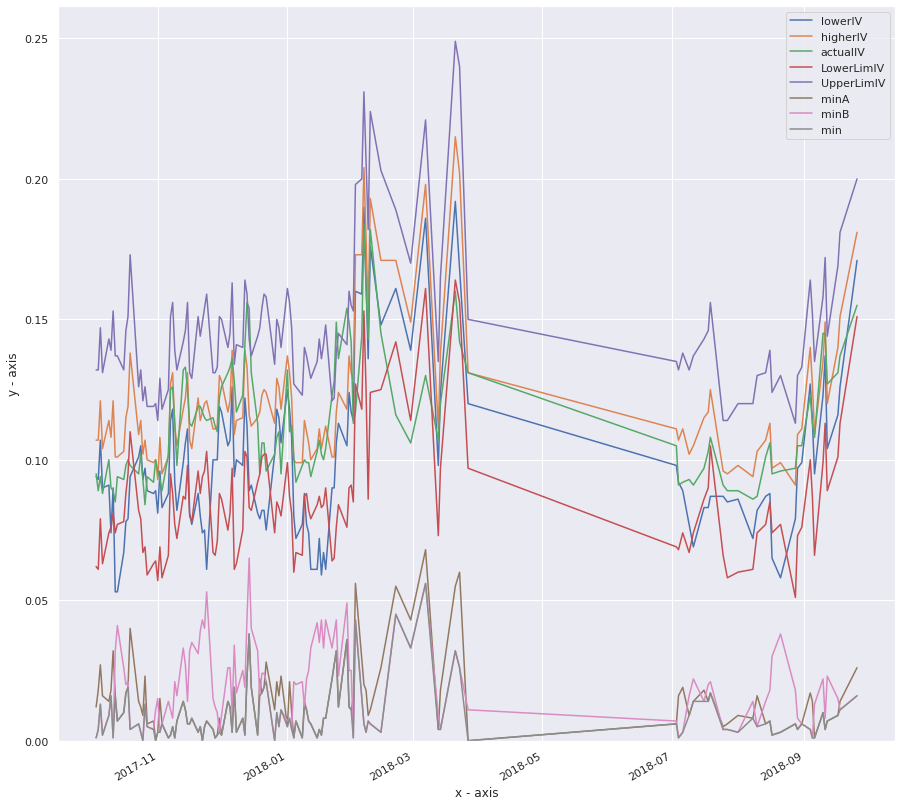

In [5]:
# sns.set()
# plt.rcParams['figure.figsize'] = [15, 15]
# # plt.scatter(vola_dataSet.index, vola_dataSet['actualIV'], label = "Actual") 
  
# # plt.scatter(vola_dataSet.index, vola_dataSet['lowerIV'], label = "Lower")

# # plt.scatter(vola_dataSet.index, vola_dataSet['higherIV'], label = "Higher")

# vola_dataSet.plot()


# plt.ylim(bottom=0)

# plt.xlabel('x - axis') 
# # naming the y axis 
# plt.ylabel('y - axis') 
# # giving a title to my graph   
# # show a legend on the plot 
# plt.legend() 
  
# # function to show the plot 
# plt.show() 

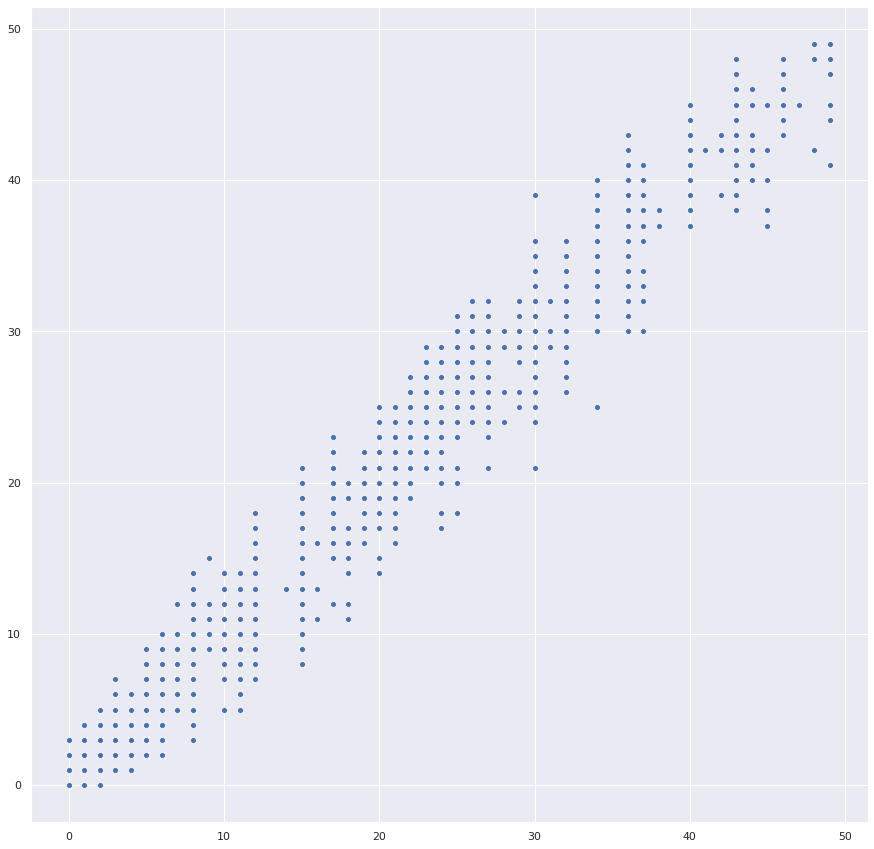

In [6]:
sns.scatterplot(Y_pred, OGY_test)
# Y_test

vola_dataSet
vola_dataSet= vola_dataSet[vola_dataSet['lowerIV']!=10000]
vola_dataSet= vola_dataSet[vola_dataSet['higherIV']!=10000]

Lower=317.8
Higher=329.1500000000001
Actual=324.8
S=11713.2
K=11350.0
TTM=2.0
R=6.18